In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

In [ ]:
import os
print("Current directory:", os.getcwd())
print("\nFiles in current directory:")
print(os.listdir())

Current directory: /content

Files in current directory:
['.config', 'sample_data']


In [ ]:
from google.colab import drive
import os

# Քայլ 1: Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

def find_folder(root_path, folder_name):
    for dirpath, dirnames, filenames in os.walk(root_path):
        if folder_name in dirnames:
            return os.path.join(dirpath, folder_name)
    return None

# Փնտրեք archive պանակը
archive_path = find_folder('/content/drive/MyDrive', 'archive')
if archive_path:
    print(f" Գտնվեց: {archive_path}")
else:
    print("'archive' պանակը չգտնվեց Google Drive-ում")

 Գտնվեց: /content/drive/MyDrive/archive


In [ ]:
import zipfile
import os

# Մեր archive.zip ֆայլի ճանապարհը
zip_file_path = '/content/drive/MyDrive/archive/archive.zip'

# Unzip անել /content պանակում (ավելի արագ է քան Drive-ում)
extract_to = '/content/potato_data'

print(" Unzip անում ենք...")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(" Unzip-ը ավարտված է!")

# Ստուգենք ինչ կա ներսում
print("\n Unzip-ված պանակները:")
for item in os.listdir(extract_to):
    item_path = os.path.join(extract_to, item)
    if os.path.isdir(item_path):
        num_files = len(os.listdir(item_path))
        print(f"  - {item}: {num_files} ֆայլ")

 Unzip անում ենք...
 Unzip-ը ավարտված է!

 Unzip-ված պանակները:
  - Potato___Early_blight: 1000 ֆայլ
  - Potato___healthy: 152 ֆայլ
  - Potato___Late_blight: 1000 ֆայլ
  - archive: 3 ֆայլ


In [ ]:
#Սահմանենք data_dir-ը
# Հիմա օգտագործենք unzip արված պանակը
data_dir = '/content/potato_data'

# Ստուգենք կլասները
print("\n Կարտոֆիլի կլասները:")
classes = []
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))])
        classes.append(folder)
        print(f"  - {folder}: {num_images} նկար")

print(f"\n Ընդամենը {len(classes)} կլաս")


 Կարտոֆիլի կլասները:
  - Potato___Early_blight: 0 նկար
  - Potato___healthy: 0 նկար
  - Potato___Late_blight: 0 նկար
  - archive: 0 նկար

 Ընդամենը 4 կլաս


In [ ]:
#Շարունակենք մոդելի ստեղծումը
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generator-ներ
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Training data
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Validation data
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("\nՊատրաստ է training-ի համար!")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 3444 images belonging to 4 classes.
Found 860 images belonging to 4 classes.

Պատրաստ է training-ի համար!
Training samples: 3444
Validation samples: 860


In [ ]:
#Կառուցենք CNN  մոդելը
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Քայլ 1: Կառուցեք մոդելը
print(" Կառուցում ենք մոդելը...")

# Օգտագործենք MobileNetV2 (արագ և ճշգրիտ)
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze անենք base layers-ը

# Ավելացնենք custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 կլաս
])

# Compile անենք
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" Մոդելը պատրաստ է!")
model.summary()

 Կառուցում ենք մոդելը...
 Մոդելը պատրաստ է!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#Train անենք մոդելը
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

# Train անենք
print(" Սկսում ենք training-ը...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

print("\n Training-ը ավարտված է!")

 Սկսում ենք training-ը...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.4596 - loss: 1.1914 - val_accuracy: 0.2791 - val_loss: 0.9398 - learning_rate: 0.0010
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.5138 - loss: 0.8593 - val_accuracy: 0.3163 - val_loss: 0.9087 - learning_rate: 0.0010
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5274 - loss: 0.8096 - val_accuracy: 0.4291 - val_loss: 0.7867 - learning_rate: 0.0010
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.5241 - loss: 0.7968 - val_accuracy: 0.3198 - val_loss: 0.8146 - learning_rate: 0.0010
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.5336 - loss: 0.7900 - val_accuracy: 0.2523 - val_loss: 0.8812 - learning_rate: 0.0010
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.5382 - loss: 0.7785 - val_accuracy: 0.3326 - val_loss: 0.7990 - learning_rate: 0.0010
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.5275 - loss: 0.

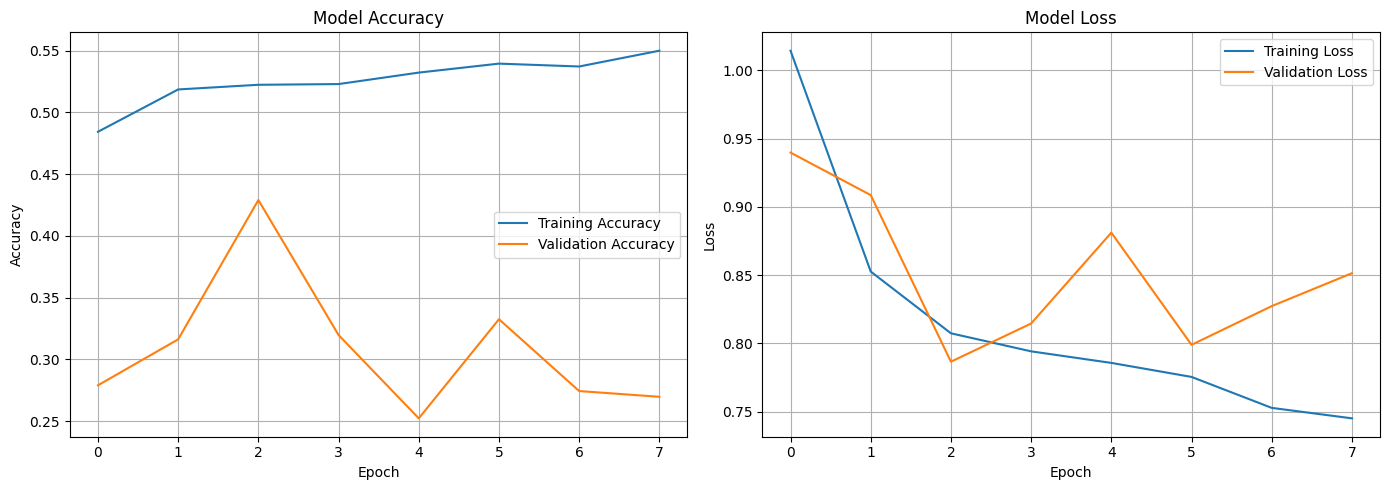


 Վերջնական արդյունքներ:
Training Accuracy: 0.5499
Validation Accuracy: 0.2698


In [ ]:
#Ցույց տանք արդյունքները
import matplotlib.pyplot as plt

# Accuracy և Loss գրաֆիկներ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Վերջնական արդյունքներ
print("\n Վերջնական արդյունքներ:")
print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [ ]:
#Պահպանենք մոդելը
# Պահպանել Google Drive-ում
model.save('/content/drive/MyDrive/archive/potato_disease_model.h5')
print("Մոդելը պահպանված է Google Drive-ում!")

Մոդելը պահպանված է Google Drive-ում!


In [ ]:
#Ուղղենք խնդիրները
import os
import shutil

# Քայլ 1: Մաքրենք data-ն - թողնենք միայն 3 կլասը
data_dir = '/content/potato_data'

# Ստուգեք ինչ կլասներ կան
print(" Հիմիկվա կլասները:")
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path)
                         if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
        print(f"  - {folder}: {num_images} նկար")

# Եթե կան ավելորդ պանակներ, ջնջեք սրանով:
folders_to_keep = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path) and folder not in folders_to_keep:
        print(f" Ջնջում ենք: {folder}")
        shutil.rmtree(folder_path)

 Հիմիկվա կլասները:
  - Potato___Early_blight: 1000 նկար
  - Potato___healthy: 152 նկար
  - Potato___Late_blight: 1000 նկար
  - archive: 0 նկար
 Ջնջում ենք: archive


In [ ]:
#Ավելի լավ մոդել - Unfreeze անենք և օպտիմալացնենք
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf

# Նոր մոդել՝ ավելի լավ պարամետրերով
print(" Կառուցում ենք բարելավված մոդելը...")

base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze վերջին 30 layers-ը
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Ավելի խորը network
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # 3 կլաս
])

# Compile՝ ավելի լավ optimizer-ով
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" Բարելավված մոդելը պատրաստ է!")
model.summary()

 Կառուցում ենք բարելավված մոդելը...
 Բարելավված մոդելը պատրաստ է!


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,347 (10.01 MB)

 Trainable params: 1,890,691 (7.21 MB)

 Non-trainable params: 734,656 (2.80 MB)

In [ ]:
#Նոր Data Generators - ավելի շատ augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data - ավելի ագրեսիվ augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"\n Training samples: {train_generator.samples}")
print(f" Validation samples: {validation_generator.samples}")
print(f" Կլասներ: {list(train_generator.class_indices.keys())}")

Found 1722 images belonging to 3 classes.
Found 430 images belonging to 3 classes.

 Training samples: 1722
 Validation samples: 430
 Կլասներ: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
#Train անենք նորից
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=0.000001,
        verbose=1
    ),
    ModelCheckpoint(
        '/content/best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print(" Սկսում ենք training-ը...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

 Սկսում ենք training-ը...
Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5200 - loss: 1.1720
Epoch 1: val_accuracy improved from -inf to 0.83256, saving model to /content/best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5221 - loss: 1.1667 - val_accuracy: 0.8326 - val_loss: 0.5233 - learning_rate: 1.0000e-04
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8418 - loss: 0.4225
Epoch 2: val_accuracy improved from 0.83256 to 0.90930, saving model to /content/best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.8421 - loss: 0.4216 - val_accuracy: 0.9093 - val_loss: 0.2904 - learning_rate: 1.0000e-04
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9098 - loss: 0.2609
Epoch 3: val_accuracy improved from 0.90930 to 0.93488, saving model to /content/best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.9097 - loss: 0.2611 - val_accuracy: 0.9349 - val_loss: 0.1978 - learning_rate: 1.0000e-04
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9300 - loss: 0.2107
Epoch 4: val_accuracy improved from 0.93488 to 0.93721, saving model to /content/best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9298 - loss: 0.2109 - val_accuracy: 0.9372 - val_loss: 0.1677 - learning_rate: 1.0000e-04
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9347 - loss: 0.1783
Epoch 5: val_accuracy did not improve from 0.93721
54/54 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9348 - loss: 0.1783 - val_accuracy: 0.9279 - val_loss: 0.1692 - learning_rate: 1.0000e-04
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9590 - loss: 0.1203
Epoch 6: val_accuracy did not improve from 0.93721
54/54 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9589 - loss: 0.1206 - val_accuracy: 0.9233 - val_loss: 0.1804 - learning_rate: 1.0000e-04
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9433 - loss: 0.1791
Epoch 7: val_accuracy improved from 0.93721 to 0.96279, saving model to /content/best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9434 - loss: 0.1786 - val_accuracy: 0.9628 - val_loss: 0.1085 - learning_rate: 1.0000e-04
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9508 - loss: 0.1414
Epoch 8: val_accuracy improved from 0.96279 to 0.98140, saving model to /content/best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9508 - loss: 0.1411 - val_accuracy: 0.9814 - val_loss: 0.0722 - learning_rate: 1.0000e-04
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9664 - loss: 0.0951
Epoch 9: val_accuracy did not improve from 0.98140
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9664 - loss: 0.0951 - val_accuracy: 0.9744 - val_loss: 0.0948 - learning_rate: 1.0000e-04
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9680 - loss: 0.0975
Epoch 10: val_accuracy did not improve from 0.98140
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9679 - loss: 0.0975 - val_accuracy: 0.9651 - val_loss: 0.0858 - learning_rate: 1.0000e-04
Epoch 11/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9676 - loss: 0.0937
Epoch 11: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 11: val_accuracy did not improve from 0.98140
54/54 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9676 - loss: 0.0937 - val_accura

54/54 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9698 - loss: 0.0787 - val_accuracy: 0.9907 - val_loss: 0.0440 - learning_rate: 3.0000e-05
Epoch 16/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9700 - loss: 0.0813
Epoch 16: val_accuracy did not improve from 0.99070
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9699 - loss: 0.0814 - val_accuracy: 0.9860 - val_loss: 0.0456 - learning_rate: 3.0000e-05
Epoch 17/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9767 - loss: 0.0756
Epoch 17: val_accuracy did not improve from 0.99070
54/54 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9767 - loss: 0.0755 - val_accuracy: 0.9721 - val_loss: 0.0852 - learning_rate: 3.0000e-05
Epoch 18/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9795 - loss: 0.0584
Epoch 18: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.

Epoch 18: val_accuracy did not improve from 0.99070
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9795 - loss: 0.0588 - val_accura

 ՎԵՐՋՆԱԿԱՆ ԱՐԴՅՈՒՆՔՆԵՐ

Լավագույն Training Accuracy: 0.9837 (98.37%)
 Լավագույն Validation Accuracy: 0.9907 (99.07%)
 Լավագույն Training Loss: 0.0565
Լավագույն Validation Loss: 0.0433


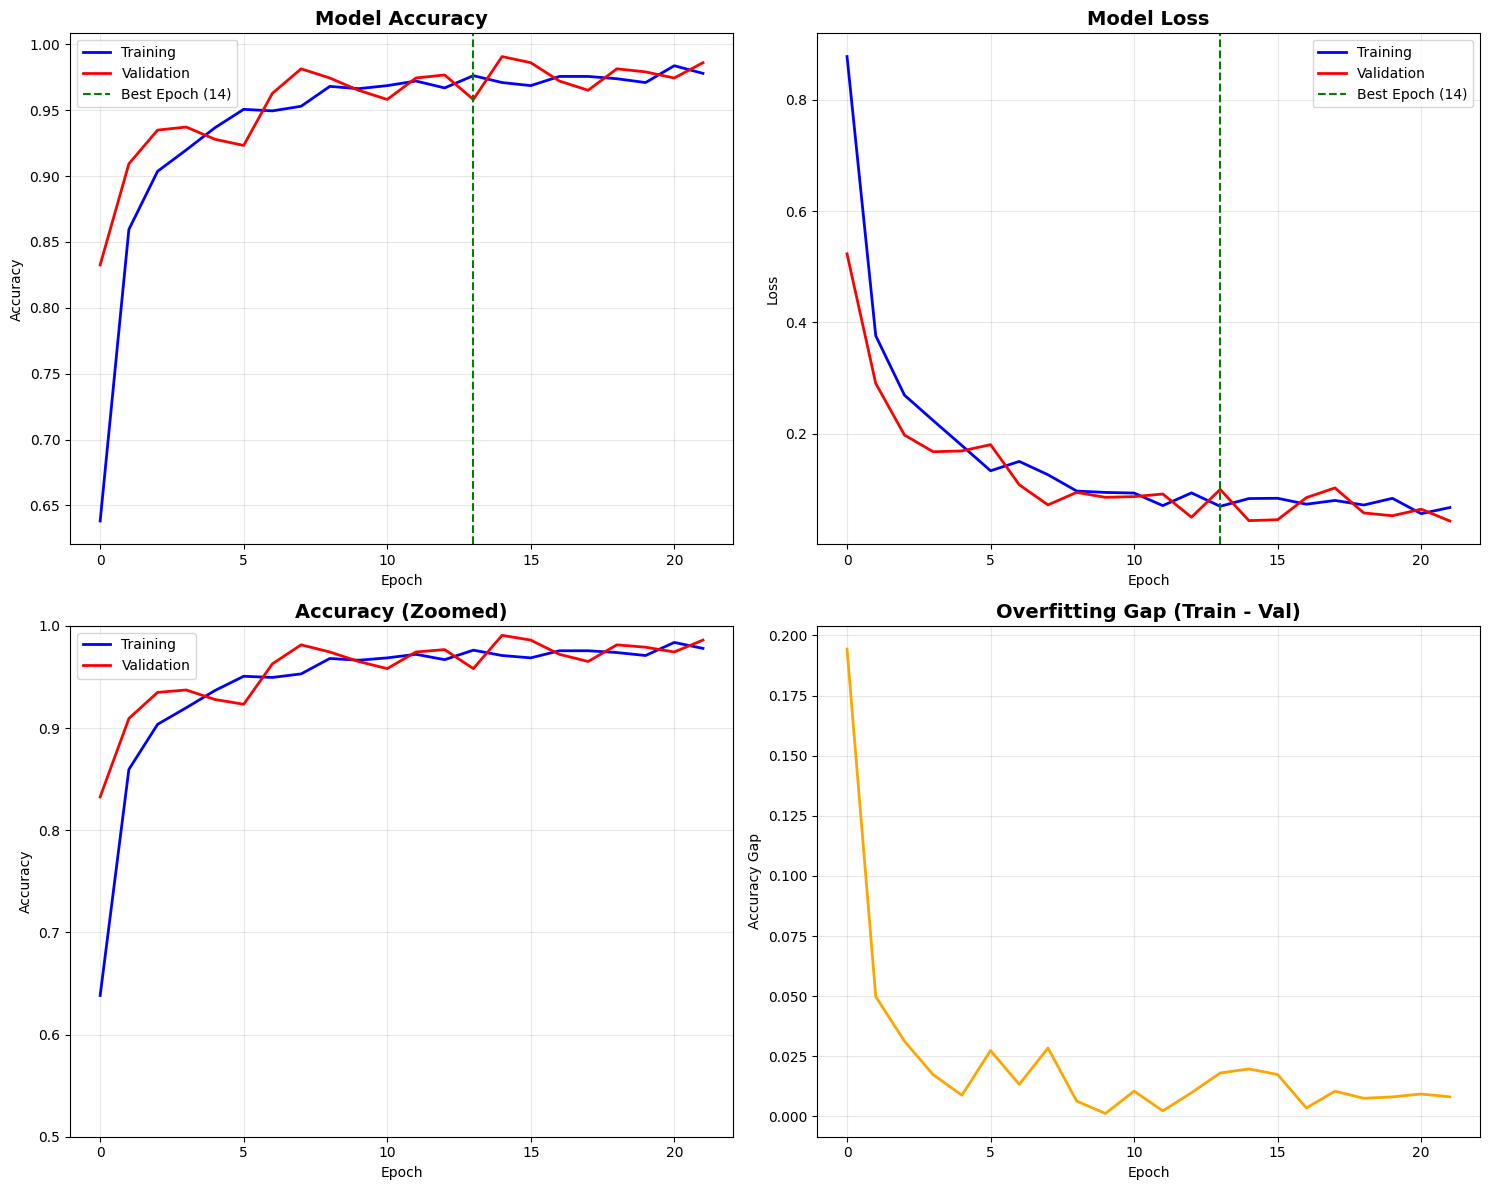

In [ ]:
#Տեսնենք վերջնական արդյունքները
import matplotlib.pyplot as plt

# Վերջնական արդյունքներ

print(" ՎԵՐՋՆԱԿԱՆ ԱՐԴՅՈՒՆՔՆԵՐ")

final_train_acc = max(history.history['accuracy'])
final_val_acc = max(history.history['val_accuracy'])
final_train_loss = min(history.history['loss'])
final_val_loss = min(history.history['val_loss'])

print(f"\nԼավագույն Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f" Լավագույն Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f" Լավագույն Training Loss: {final_train_loss:.4f}")
print(f"Լավագույն Validation Loss: {final_val_loss:.4f}")

# Գրաֆիկներ
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], 'b-', label='Training', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
axes[0, 0].axvline(x=13, color='green', linestyle='--', label='Best Epoch (14)')
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], 'b-', label='Training', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], 'r-', label='Validation', linewidth=2)
axes[0, 1].axvline(x=13, color='green', linestyle='--', label='Best Epoch (14)')
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Accuracy zoom (վերջին epochs)
axes[1, 0].plot(history.history['accuracy'], 'b-', label='Training', linewidth=2)
axes[1, 0].plot(history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
axes[1, 0].set_title('Accuracy (Zoomed)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_ylim([0.5, 1.0])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Overfitting ցուցիչ
gap = [abs(t - v) for t, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
axes[1, 1].plot(gap, 'orange', linewidth=2)
axes[1, 1].set_title('Overfitting Gap (Train - Val)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy Gap')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


 Կանխատեսում ենք validation data-ի վրա...
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step

 CLASSIFICATION REPORT
                       precision    recall  f1-score   support

Potato___Early_blight       0.99      0.99      0.99       200
 Potato___Late_blight       0.99      0.94      0.97       200
     Potato___healthy       0.77      1.00      0.87        30

             accuracy                           0.97       430
            macro avg       0.92      0.98      0.94       430
         weighted avg       0.98      0.97      0.97       430



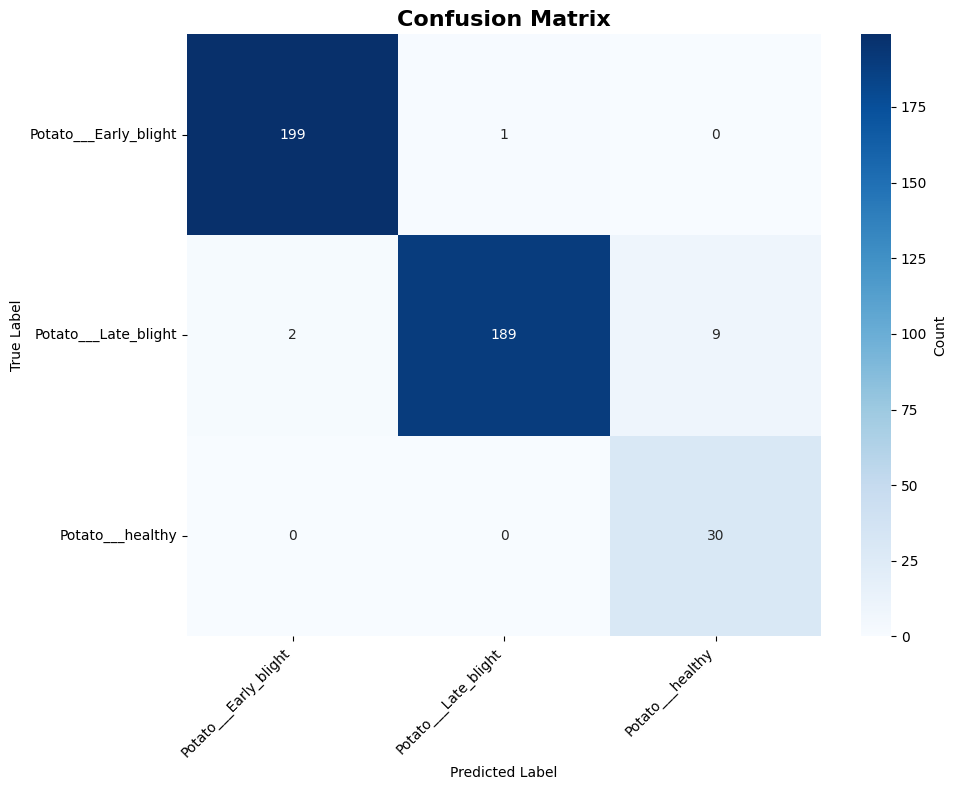


 ACCURACY ԸՍՏ ԿԼԱՍԻ:
Potato___Early_blight          99.50%
Potato___Late_blight           94.50%
Potato___healthy               100.00%


In [ ]:
#Թեստավորենք մոդելը
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predictions
print("\n Կանխատեսում ենք validation data-ի վրա...")
validation_generator.reset()
y_pred_probs = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator.classes

# Class names
class_names = list(validation_generator.class_indices.keys())

# Classification Report
print("\n CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Ըստ կլասի accuracy
print("\n ACCURACY ԸՍՏ ԿԼԱՍԻ:")
for i, class_name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum()
    print(f"{class_name:30} {class_acc:.2%}")

In [ ]:
#Պահպանենք լավագույն մոդելը
# Բեռնել լավագույն մոդելը
best_model = tf.keras.models.load_model('/content/best_model.h5')

# Պահպանել Google Drive-ում
best_model.save('/content/drive/MyDrive/archive/potato_disease_best_model.h5')
print(" Լավագույն մոդելը պահպանված է Google Drive-ում!")

# Պահպանել նաև .keras ֆորմատով (ավելի նոր)
best_model.save('/content/drive/MyDrive/archive/potato_disease_model.keras')
print(" Մոդելը պահպանված է .keras ֆորմատով!")

 Լավագույն մոդելը պահպանված է Google Drive-ում!
 Մոդելը պահպանված է .keras ֆորմատով!


🧪 Թեստավորում ենք պատահական նկարներ...

 Իրական կլաս: Potato___healthy


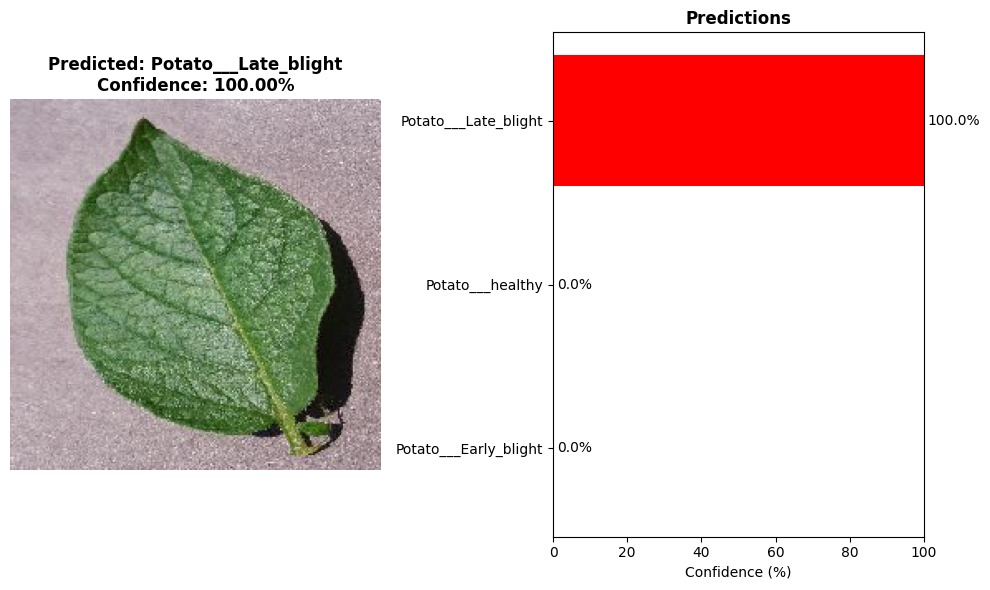

 Կանխատեսված: Potato___Late_blight
 Ճիշտ է: Ոչ
----------------------------------------------------------------------
 Իրական կլաս: Potato___Early_blight


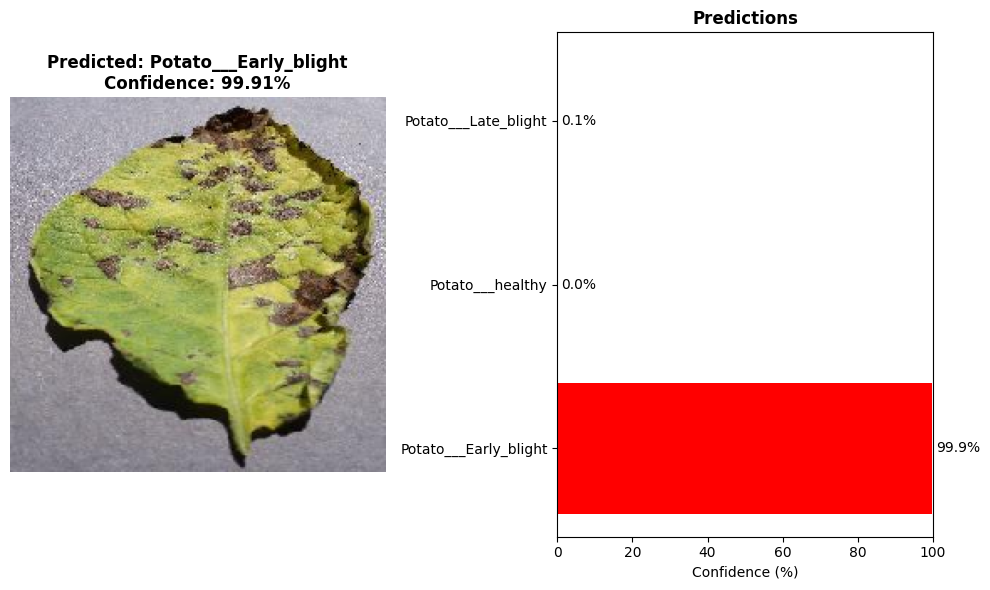

 Կանխատեսված: Potato___Early_blight
 Ճիշտ է: Այո
----------------------------------------------------------------------
 Իրական կլաս: Potato___Late_blight


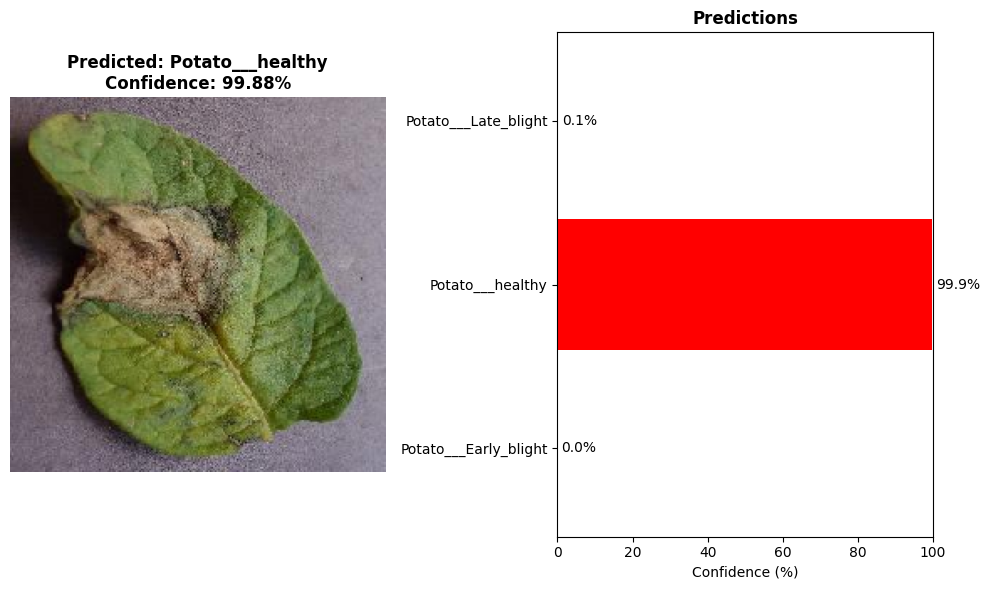

 Կանխատեսված: Potato___healthy
 Ճիշտ է: Ոչ
----------------------------------------------------------------------
 Իրական կլաս: Potato___Late_blight


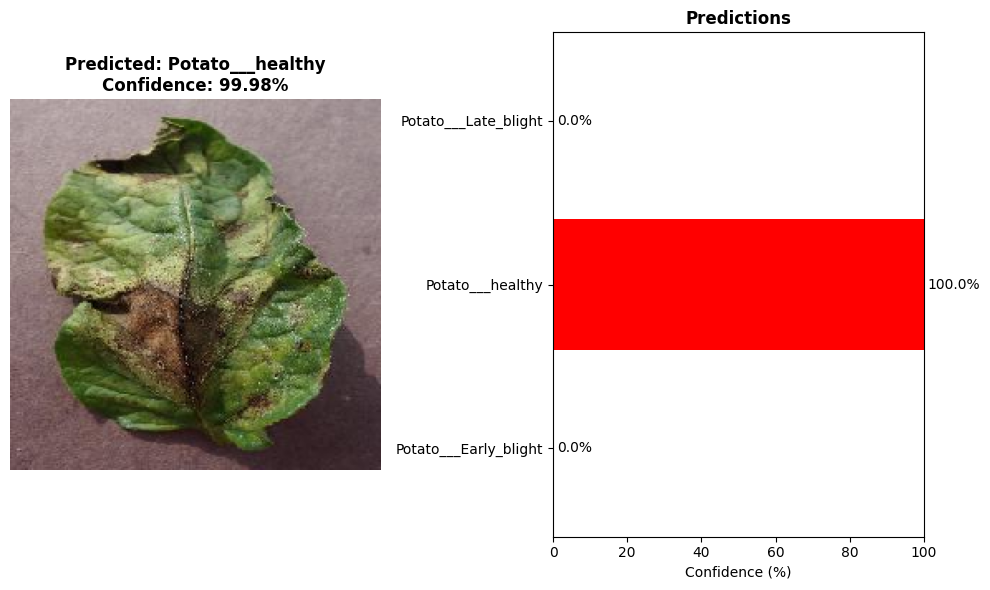

 Կանխատեսված: Potato___healthy
 Ճիշտ է: Ոչ
----------------------------------------------------------------------
 Իրական կլաս: Potato___Early_blight


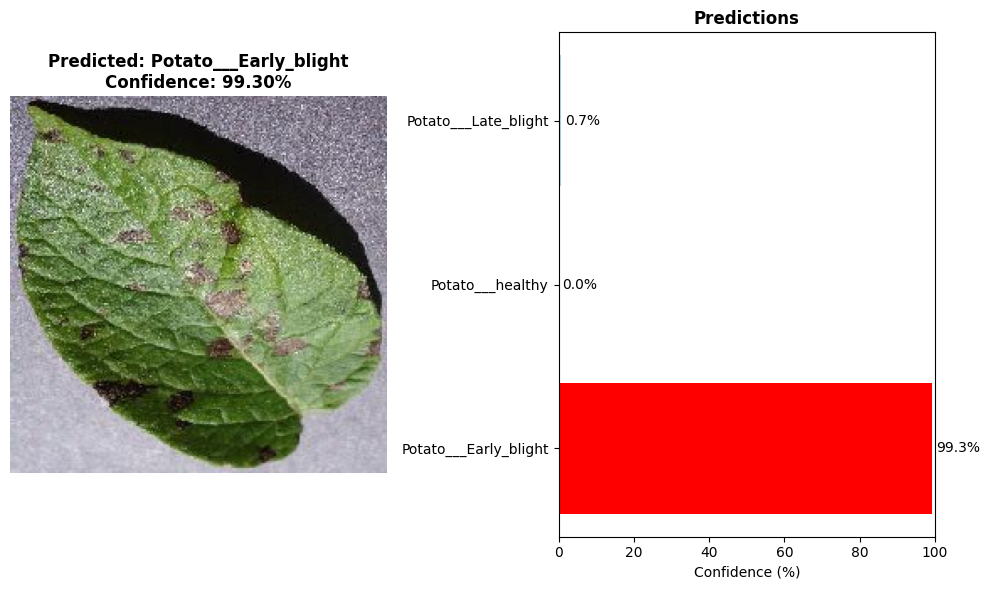

 Կանխատեսված: Potato___Early_blight
 Ճիշտ է: Այո
----------------------------------------------------------------------


In [ ]:
#Հիմա թեստավորենք իրական նկարների վրա
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import random

def predict_disease(img_path, model):
    """Կանխատեսում է հիվանդությունը նկարից"""

    # Բեռնել և պատրաստել նկարը
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Կանխատեսում
    predictions = model.predict(img_array, verbose=0)
    class_names = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(predictions) * 100

    # Ցույց տալ
    plt.figure(figsize=(10, 6))

    # Նկար
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2f}%',
              fontsize=12, fontweight='bold')

    # Probabilities
    plt.subplot(1, 2, 2)
    colors = ['red' if i == np.argmax(predictions) else 'lightblue'
              for i in range(len(class_names))]
    plt.barh(class_names, predictions[0] * 100, color=colors)
    plt.xlabel('Confidence (%)')
    plt.title('Predictions', fontweight='bold')
    plt.xlim([0, 100])

    for i, v in enumerate(predictions[0] * 100):
        plt.text(v + 1, i, f'{v:.1f}%', va='center')

    plt.tight_layout()
    plt.show()

    return predicted_class, confidence

# Բեռնեք լավագույն մոդելը
best_model = tf.keras.models.load_model('/content/best_model.h5')

# Թեստավորեք պատահական նկարների վրա validation set-ից
print("🧪 Թեստավորում ենք պատահական նկարներ...\n")

# Վերցնենք 5 պատահական նկար validation set-ից
all_images = []
for class_name in ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']:
    class_path = os.path.join(data_dir, class_name)
    images = glob.glob(os.path.join(class_path, '*.jpg')) + \
             glob.glob(os.path.join(class_path, '*.png')) + \
             glob.glob(os.path.join(class_path, '*.jpeg')) + \
             glob.glob(os.path.join(class_path, '*.JPG')) # Add uppercase JPG
    all_images.extend(images)

# Check if all_images is empty or not enough images
if len(all_images) == 0:
    print("Չեն հայտնաբերվել նկարներ թեստավորման համար։")
elif len(all_images) < 5:
    print(f"Զգուշացում: Հայտնաբերվել է ընդամենը {len(all_images)} նկար։")
    num_samples = len(all_images) # Sample all available images
else:
    num_samples = 5

if num_samples > 0:
    sample_images = random.sample(all_images, num_samples)

    for img_path in sample_images:
        true_class = os.path.basename(os.path.dirname(img_path))
        print(f" Իրական կլաս: {true_class}")
        predicted_class, confidence = predict_disease(img_path, best_model)
        print(f" Կանխատեսված: {predicted_class}")
        print(f" Ճիշտ է: {'Այո' if true_class == predicted_class else 'Ոչ'}")
        print("-" * 70)


 ԽՈՐԸ ՎԵՐԼՈՒԾՈՒԹՅՈՒՆ

 Թեստավորում ենք ամբողջ validation set-ը...

 Թեստավորված: 430 նկար
 Ճիշտ: 413 (96.05%)
 Սխալ: 17 (3.95%)

 Գտնվեց 17 սխալ։ Ցույց ենք տալիս առաջին 10-ը:



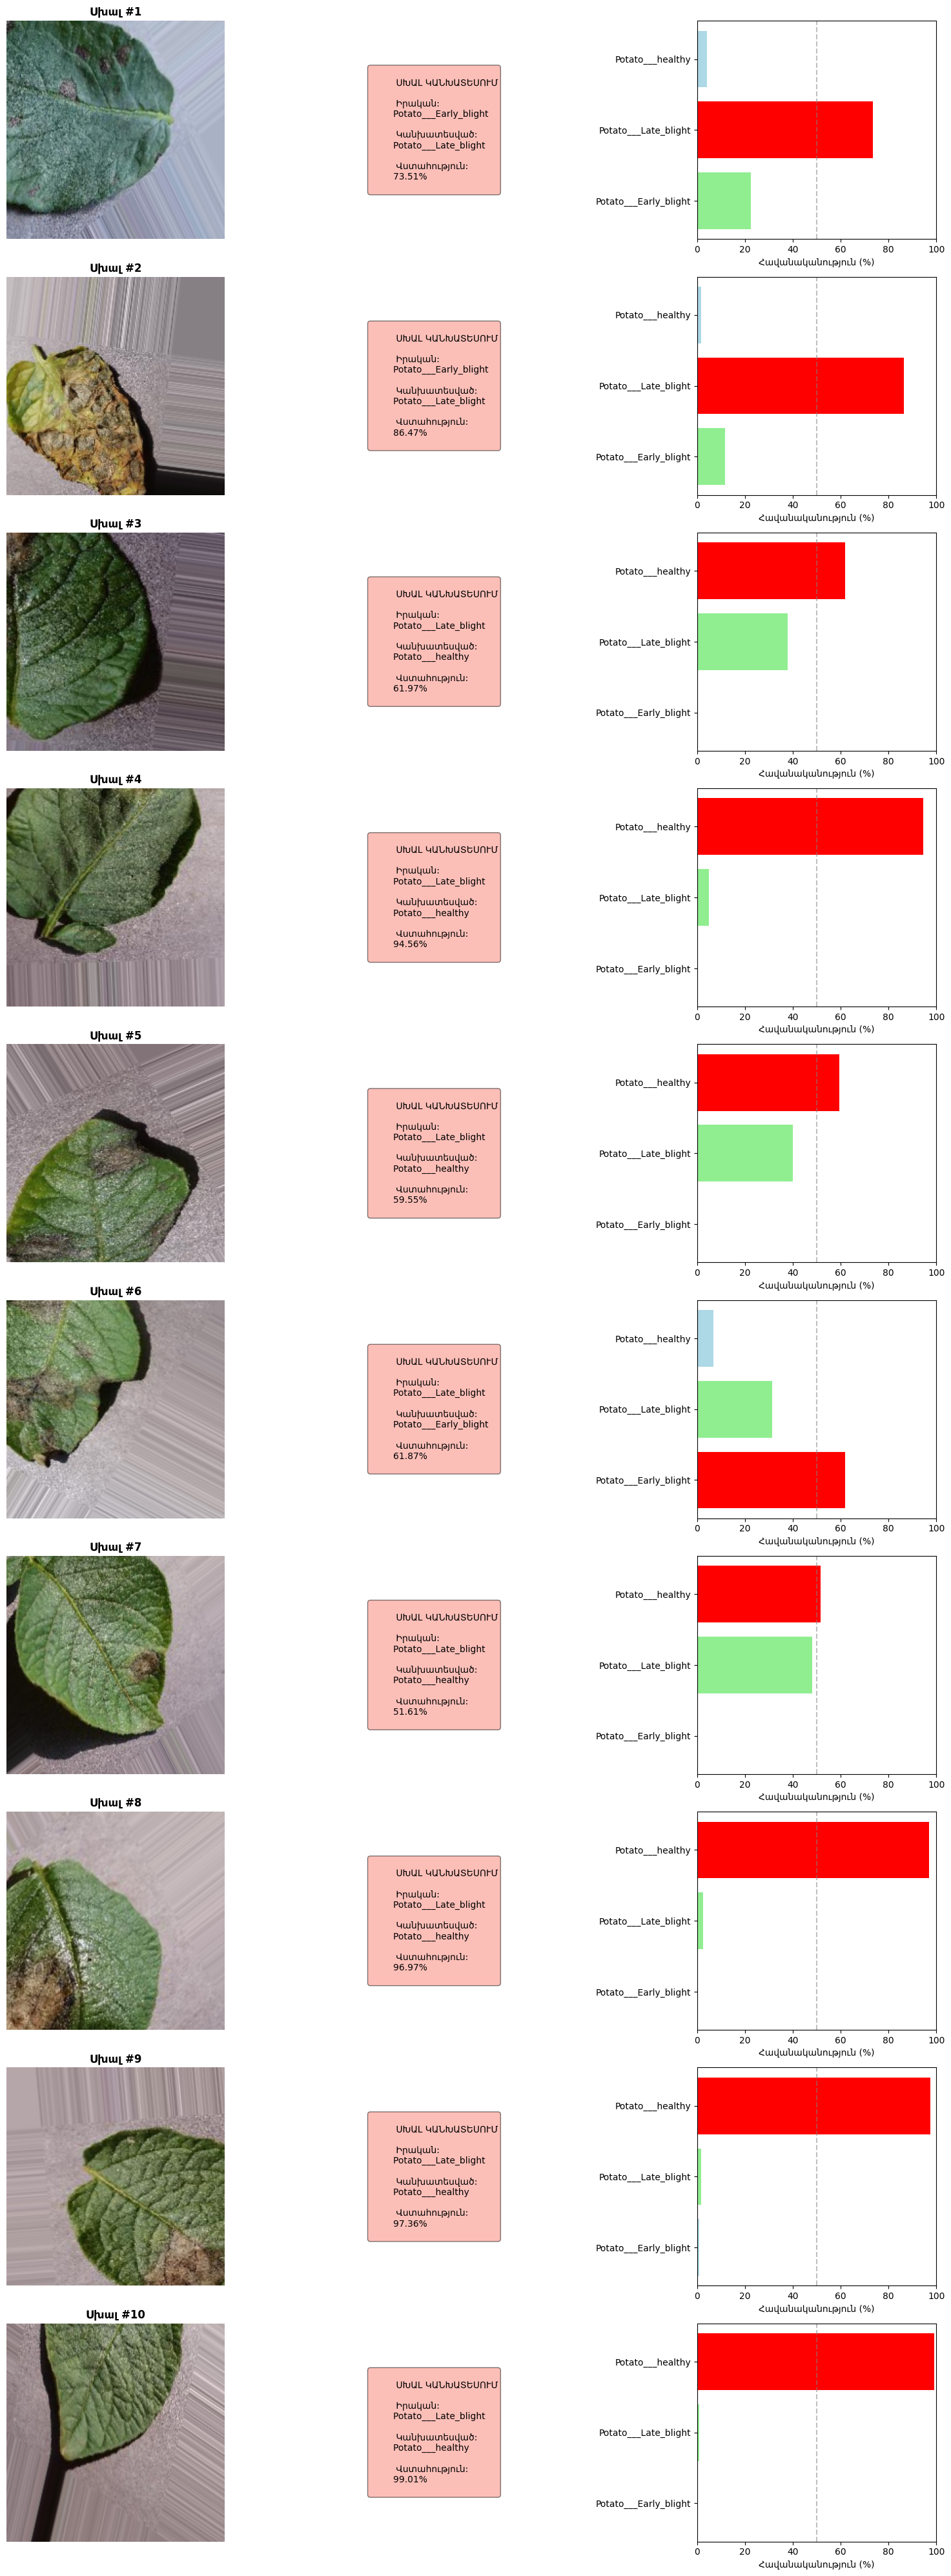


 ՍԽԱԼՆԵՐԻ ՎԻՃԱԿԱԳՐՈՒԹՅՈՒՆ:

 Սխալներ ըստ իրական կլասի:
  Potato___Early_blight            2 սխալ
  Potato___Late_blight            12 սխալ
  Potato___healthy                 3 սխալ

 Սխալներ ըստ կանխատեսված կլասի:
  Potato___Late_blight             5 սխալ
  Potato___healthy                 8 սխալ
  Potato___Early_blight            4 սխալ

🔄 Ամենից հաճախ շփոթվող զույգերը:
  Potato___Late_blight → Potato___healthy: 8 անգամ
  Potato___Late_blight → Potato___Early_blight: 4 անգամ
  Potato___healthy → Potato___Late_blight: 3 անգամ
  Potato___Early_blight → Potato___Late_blight: 2 անգամ


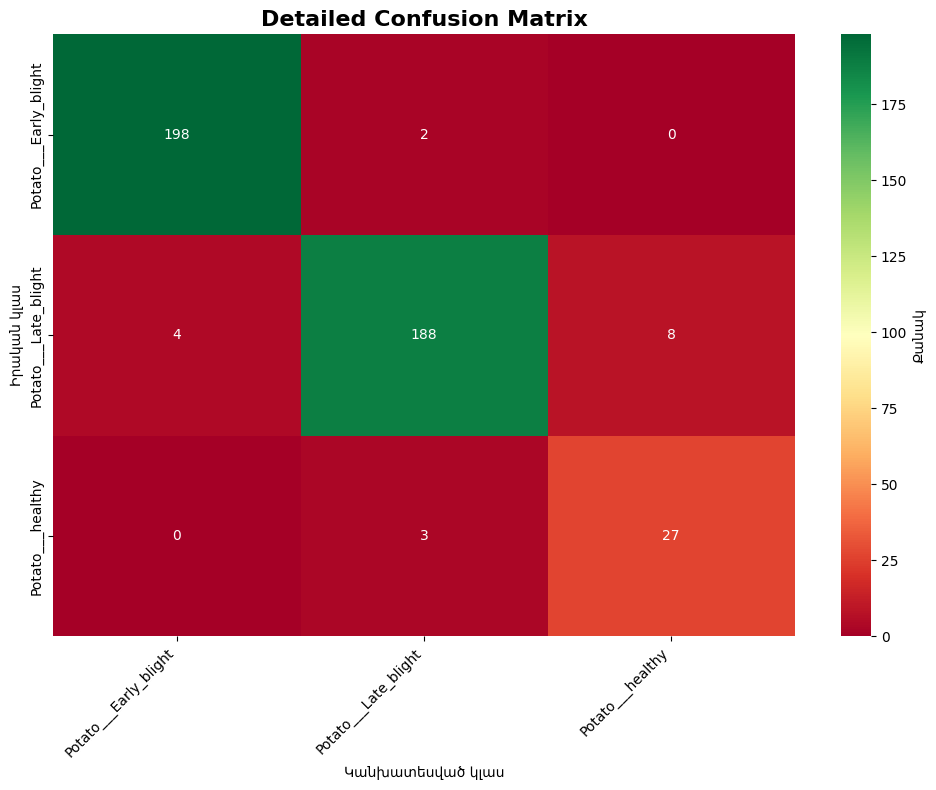

In [ ]:
#Խորը վերլուծություն
import matplotlib.pyplot as plt
import numpy as np

print(" ԽՈՐԸ ՎԵՐԼՈՒԾՈՒԹՅՈՒՆ\n")

# Վերցնենք ավելի շատ նկարներ և ստուգենք սխալները
validation_generator.reset()

total_tested = 0
correct = 0
errors = []

# Թեստավորենք ամբողջ validation set-ը
print(" Թեստավորում ենք ամբողջ validation set-ը...")

y_true_all = []
y_pred_all = []

for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    predictions = best_model.predict(x_batch, verbose=0)

    for j in range(len(x_batch)):
        true_idx = np.argmax(y_batch[j])
        pred_idx = np.argmax(predictions[j])

        y_true_all.append(true_idx)
        y_pred_all.append(pred_idx)

        total_tested += 1

        if true_idx == pred_idx:
            correct += 1
        else:
            # Պահպանենք սխալները
            errors.append({
                'image': x_batch[j],
                'true_class': list(validation_generator.class_indices.keys())[true_idx],
                'pred_class': list(validation_generator.class_indices.keys())[pred_idx],
                'confidence': predictions[j][pred_idx] * 100,
                'probabilities': predictions[j]
            })

print(f"\n Թեստավորված: {total_tested} նկար")
print(f" Ճիշտ: {correct} ({correct/total_tested*100:.2f}%)")
print(f" Սխալ: {len(errors)} ({len(errors)/total_tested*100:.2f}%)")

# Ցույց տանք սխալները
if len(errors) > 0:
    print(f"\n Գտնվեց {len(errors)} սխալ։ Ցույց ենք տալիս առաջին 10-ը:\n")

    num_to_show = min(10, len(errors))

    fig, axes = plt.subplots(num_to_show, 3, figsize=(15, num_to_show * 4))
    if num_to_show == 1:
        axes = axes.reshape(1, -1)

    for i, error in enumerate(errors[:num_to_show]):
        # Նկար
        axes[i, 0].imshow(error['image'])
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f'Սխալ #{i+1}', fontweight='bold')

        # Տեղեկություն
        axes[i, 1].axis('off')
        info_text = f"""
         ՍԽԱԼ ԿԱՆԽԱՏԵՍՈՒՄ

         Իրական:
        {error['true_class']}

         Կանխատեսված:
        {error['pred_class']}

         Վստահություն:
        {error['confidence']:.2f}%
        """
        axes[i, 1].text(0.1, 0.5, info_text, fontsize=10,
                       verticalalignment='center',
                       bbox=dict(boxstyle='round', facecolor='salmon', alpha=0.5))

        # Probabilities
        class_names = list(validation_generator.class_indices.keys())
        true_idx = class_names.index(error['true_class'])
        pred_idx = class_names.index(error['pred_class'])

        colors = ['red' if j == pred_idx else 'lightgreen' if j == true_idx else 'lightblue'
                 for j in range(len(class_names))]

        axes[i, 2].barh(class_names, error['probabilities'] * 100, color=colors)
        axes[i, 2].set_xlabel('Հավանականություն (%)')
        axes[i, 2].set_xlim([0, 100])
        axes[i, 2].axvline(x=50, color='gray', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Վիճակագրություն սխալների մասին
    print("\n ՍԽԱԼՆԵՐԻ ՎԻՃԱԿԱԳՐՈՒԹՅՈՒՆ:")
    print("="*70)

    from collections import Counter

    # Ըստ իրական կլասի
    true_class_errors = Counter([e['true_class'] for e in errors])
    print("\n Սխալներ ըստ իրական կլասի:")
    for class_name, count in true_class_errors.items():
        print(f"  {class_name:30} {count:3d} սխալ")

    # Ըստ կանխատեսված կլասի
    pred_class_errors = Counter([e['pred_class'] for e in errors])
    print("\n Սխալներ ըստ կանխատեսված կլասի:")
    for class_name, count in pred_class_errors.items():
        print(f"  {class_name:30} {count:3d} սխալ")

    # Confusion pairs
    print("\n Ամենից հաճախ շփոթվող զույգերը:")
    confusion_pairs = Counter([(e['true_class'], e['pred_class']) for e in errors])
    for (true_c, pred_c), count in confusion_pairs.most_common(5):
        print(f"  {true_c} → {pred_c}: {count} անգամ")

else:
    print("\n Չկան սխալներ! Մոդելը կատարյալ է!")

# Detailed confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true_all, y_pred_all)
class_names = list(validation_generator.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Քանակ'})
plt.title('Detailed Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('Իրական կլաս')
plt.xlabel('Կանխատեսված կլաս')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n" + "="*70)

In [ ]:
# ՏԵՂԱԴՐԵԼ STREAMLIT ԵՎ ԱՆՀՐԱԺԵՇՏ ԳՐԱԴԱՐԱՆՆԵՐԸ
print(" Տեղադրում ենք Streamlit...")
!pip install -q streamlit pyngrok

print(" Streamlit տեղադրված է!")

 Տեղադրում ենք Streamlit...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 25.0 MB/s eta 0:00:00
 Streamlit տեղադրված է!


In [ ]:
#ՍՏԵՂԾԵԼ APP.PY ՖԱՅԼԸ
print("\n Ստեղծում ենք app.py ֆայլը...")


 Ստեղծում ենք app.py ֆայլը...


In [ ]:
%%writefile app.py
"""
 ԿԱՐՏՈՖԻԼԻ ՀԻՎԱՆԴՈՒԹՅՈՒՆՆԵՐԻ ԱԽՏՈՐՈՇԻՉ
Հայաստանի ֆերմերների համար
"""

import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
from datetime import datetime
import json
import os



Writing app.py


In [ ]:
#Քայլ 1: Տեղադրել Streamlit
!pip install -q streamlit pyngrok
print(" Streamlit տեղադրված է!")

 Streamlit տեղադրված է!


In [ ]:
#Քայլ 2: Ստեղծել app.py ֆայլը
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image

st.set_page_config(
    page_title=" Կարտոֆիլի ախտորոշիչ",
    page_icon=" ",
    layout="wide"
)

st.markdown("""
<style>
    .main-header {
        font-size: 2.5rem;
        font-weight: bold;
        text-align: center;
        padding: 1.5rem;
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        border-radius: 10px;
        margin-bottom: 2rem;
    }
    .result-box {
        padding: 2rem;
        border-radius: 15px;
        margin: 1rem 0;
        box-shadow: 0 4px 6px rgba(0,0,0,0.1);
    }
    .healthy {
        background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%);
        color: white;
    }
    .disease {
        background: linear-gradient(135deg, #eb3349 0%, #f45c43 100%);
        color: white;
    }
    .warning {
        background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%);
        color: white;
    }
</style>
""", unsafe_allow_html=True)

@st.cache_resource
def load_model():
    try:
        model = tf.keras.models.load_model('potato_disease_model.keras')
        return model
    except Exception as e:
        st.error(f" Մոդելը չբեռնվեց։ {e}")
        return None

DISEASE_INFO = {
    'Potato___healthy': {
        'name_hy': ' Առողջ կարտոֆիլ',
        'severity': 'low',
        'description': ' Շնորհավորում ենք! Ձեր կարտոֆիլը առողջ է։',
        'recommendations': [
            " Շարունակեք կանոնավոր ջրել",
            " Օգտագործեք օրգանական պարարտանյութեր",
            " Կանոնավոր ստուգեք տերևները"
        ]
    },
    'Potato___Early_blight': {
        'name_hy': 'Վաղ մանրէ',
        'severity': 'medium',
        'description': ' Վաղ մանրէ հայտնաբերված է։',
        'symptoms': [
            " Շագանակագույն բծեր",
            " Կոնցենտրիկ օղակներ",
            " Տերևների չորանում"
        ],
        'recommendations': [
            "Հեռացրեք վարակված տերևները",
            "ty': 'high',
        'description': ' ՎՏԱՆԳ! Ուշ մանրէ!',
        'symptoms': [
            " Ջրային բծեր",
            " Արագ մգանում",
            " Սպիտակ շերտ տերևի հետևից"
        ],
        'recommendations': [
            "Անմիջապես հեռացրեք վարակված բույսերը",
            "Ցողեք Ridomil Gold Plus",
            "Կրկնեք 5-7 օրը մեկ"
        ],
        'urgent': True
    }
}

def predict_disease(image, model):
    img = image.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array, verbose=0)
    class_names = ['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']
    predicted_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_idx]
    confidence = predictions[0][predicted_idx] * 100
    all_probs = {class_names[i]: predictions[0][i] * 100 for i in range(len(class_names))}
    return predicted_class, confidence, all_probs

def main():
    st.markdown('<div class="main-header"> Կարտոֆիլի հիվանդությունների ախտորոշիչ</div>', unsafe_allow_html=True)
    st.markdown('<div style="text-align: center; color: #666; margin-bottom: 2rem;">🇦🇲 Հայաստանի ֆերմերների համար</div>', unsafe_allow_html=True)

    uploaded_file = st.file_uploader(" Վերբեռնեք կարտոֆիլի տերևի լուսանկարը", type=['jpg', 'jpeg', 'png'])

    if uploaded_file:
        model = load_model()
        if model is None:
            return

        image = Image.open(uploaded_file)
        st.image(image, caption="Ձեր նկարը", use_container_width=True)

        with st.spinner(' Վերլուծում ենք...'):
            prediction, confidence, all_probs = predict_disease(image, model)

        disease_info = DISEASE_INFO[prediction]
        severity = disease_info['severity']

        box_class = 'healthy' if severity == 'low' else ('warning' if severity == 'medium' else 'disease')
        icon = ' if severity == 'low' else (' if severity == 'medium' else)

        st.markdown(f'<div class="result-box {box_class}"><h2>{icon} {disease_info["name_hy"]}</h2><p>Վստահություն: {confidence:.1f}%</p></div>', unsafe_allow_html=True)

        st.markdown(f"###  {disease_info['description']}")

        if 'symptoms' in disease_info:
            st.markdown("###  Ախտանիշներ")
            for symptom in disease_info['symptoms']:
                st.markdown(f"- {symptom}")

        st.markdown("###  Խորհուրդներ")
        if disease_info.get('urgent'):
            st.error(" ԱՆՀԱՊԱՂ ԳՈՐԾՈՂՈՒԹՅՈՒՆՆԵՐ!")

        for rec in disease_info['recommendations']:
            st.markdown(f"- {rec}")

if __name__ == "__main__":
    main()

Overwriting app.py


In [ ]:
#Քայլ 3: Պատճենել մոդելը
!cp /content/drive/MyDrive/archive/potato_disease_model.keras /content/potato_disease_model.keras
print("Մոդելը պատճենված է!")

cp: cannot stat '/content/drive/MyDrive/archive/potato_disease_model.keras': No such file or directory
Մոդելը պատճենված է!


In [ ]:

#Քայլ 4: Գործարկել Streamlit-ը
!streamlit run app.py & npx localtunnel --port 8501

⠙⠹⠸⠼

⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.168.244.42:8501

your url is: https://six-ants-win.loca.lt
